# About this Dataset
## Data overview

In the dataset freMTPL2freq risk features and claim numbers were collected for 677,991 motor third-part liability policies (observed on a year).

## Content
freMTPL2freq contains 11 columns (+IDpol):
- IDpol The policy ID (used to link with the claims dataset).
- ClaimNb Number of claims during the exposure period.
- Exposure The exposure period.
- Area The area code.
- VehPower The power of the car (ordered categorical).
- VehAge The vehicle age, in years.
- DrivAge The driver age, in years (in France, people can drive a car at 18).
- BonusMalus Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.
- VehBrand The car brand (unknown categories).
- VehGas The car gas, Diesel or regular.
- Density The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.
 Region The policy regions in France (based on a standard French classification)

freMTPL2sev contains 2 colums:
- IDpol The policy ID
- Claim amount claim amount

In [1]:
!pip install opendatasets

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import opendatasets as od

In [4]:
#Copy credencials of kaggle to correct place
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ./
!chmod 600 ~/.kaggle/kaggle.json
print("ok")

ok


In [5]:
# create folder of kaggle with url of dataset
od.download(
    "https://www.kaggle.com/datasets/floser/fremtpl2sev")

od.download(
    "https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq")


od.download(
    "https://www.kaggle.com/datasets/floser/fremtpl2freq-folds")

Skipping, found downloaded files in "./fremtpl2sev" (use force=True to force download)
Skipping, found downloaded files in "./french-motor-claims-datasets-fremtpl2freq" (use force=True to force download)
Skipping, found downloaded files in "./fremtpl2freq-folds" (use force=True to force download)


# Project Description

Machine Learning Techniques in Motor Insurance Pricing
- Models and predicts claims frequency for French motor third party liability insurance portfolio.
- Classical approach, generalized linear models (GLM)


# Table of contents

1. Preprocessing data and get ready for modeling
2. GLM
3. Summary

# 1. Preprocessing data and get ready for modeling

In [6]:
#Import libraries

import os
# Set environment variable to ignore all warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

seed= 123 # for reproducible random numbers
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import uniform, loguniform

import matplotlib.pyplot as plt
import seaborn as sns

# Models
import statsmodels.api as sm
import statsmodels.formula.api as smf # to get GLM

## 1.2 Read dataset and correct claim number

The former contains the information on the insurance policy and claims frequency and the latter the corresponding information on claims severity.

The claim counts on the insurance policies with policy IDs ≤ 24500 in the dataset FreMTPL2freq do not have claim severity counterparts in the dataset FreMTPL2sev and thus seem not to be correct. For this reason we work with the claim counts extracted from FreMTPL2sev.

In [7]:
# read frequency data
df_raw = pd.read_csv("/content/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv")
df_raw.IDpol = df_raw.IDpol.astype(int) # policy ID should be integer

df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6114330.00
ClaimNb,678013.0,5.324677e-02,2.401173e-01,0.000000,0.00,0.00,0.00,16.00
Exposure,678013.0,5.287501e-01,3.644415e-01,0.002732,0.18,0.49,0.99,2.01
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,15.00
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,100.00
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,100.00
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,230.00
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,27000.00


In [8]:
# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df_raw["Exposure"] = np.minimum(1, df_raw.Exposure)
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)

df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6114330.0
ClaimNb,678013.0,5.317892e-02,2.379544e-01,0.000000,0.00,0.00,0.00,4.0
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,0.18,0.49,0.99,1.0
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,15.0
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,100.0
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,100.0
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,230.0
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,27000.0


In [9]:
# import folds from the linked R notebook (to obtain the same subsamples and reproduce some results)
df_folds = pd.read_csv("/content/fremtpl2freq-folds/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int) # policy ID should be integer
df_folds.head(), df_folds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   IDpol   678013 non-null  int64
 1   fold    678013 non-null  int64
dtypes: int64(2)
memory usage: 10.3 MB


(   IDpol  fold
 0      1     1
 1      3     5
 2      5     1
 3     10     1
 4     11     2,
 None)

In [10]:
# Initialize an empty dictionary to store distinct values for numeric fields
distinct_values = {}

# Iterate through each column
for col in df_folds.columns:
    # Check if the column contains numeric data
    if pd.api.types.is_numeric_dtype(df_folds[col]):
        # Find distinct values for numeric fields
        distinct_values[col] = df_folds[col].unique()

# Print distinct values for numeric fields
for col, values in distinct_values.items():
    print(f"Distinct values for {col}: {values}")

Distinct values for IDpol: [      1       3       5 ... 6114328 6114329 6114330]
Distinct values for fold: [1 5 2 4 3]


In [11]:
df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')

In [12]:
print("\nNumber of data rows and columns: ", df.shape)
print("\nCheck the end of the data set (possibly corrupted data):")
df.tail(3) # view end of dataset



Number of data rows and columns:  (678013, 13)

Check the end of the data set (possibly corrupted data):


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold
678010,6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,5
678011,6114329,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,3
678012,6114330,0,0.00274,B,7,6,29,54,B12,Diesel,65,R72,5


In [13]:
# take claim number from severity file (see https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev)
sev = pd.read_csv("/content/fremtpl2sev/freMTPL2sev.csv")
sev.head(3)


,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11


In [14]:
sev["ClaimNb"] = 1
sev.head(3)


,IDpol,ClaimAmount,ClaimNb
0,1552,995.20,1
1,1010996,1128.12,1
2,4024277,1851.11,1


In [15]:
sev_agg = sev.groupby("IDpol").sum("ClaimNb").drop(columns=['ClaimAmount'])
# checks, sums and counts
sev_agg.head(3)

,ClaimNb
IDpol,
139,1
190,1
414,1


In [16]:
# left join with claims frequency data (exposures, features and without questionable ClaimNb).
df = pd.merge(df.drop(columns=['ClaimNb']), sev_agg, on="IDpol", how="left").fillna(0)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6114330.0
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,0.18,0.49,0.99,1.0
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,15.0
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,100.0
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,100.0
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,230.0
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,27000.0
fold,678013.0,2.997021e+00,1.413916e+00,1.000000,2.00,3.00,4.00,5.0
ClaimNb,678013.0,3.900220e-02,2.071656e-01,0.000000,0.00,0.00,0.00,16.0


In [17]:
# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df['ClaimNb'] = df['ClaimNb'].clip(upper=4) #(limit) the values in an array.
df['Exposure'] = df['Exposure'].clip(upper=1) #(limit) the values in an array.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6114330.0
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,0.18,0.49,0.99,1.0
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,15.0
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,100.0
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,100.0
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,230.0
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,27000.0
fold,678013.0,2.997021e+00,1.413916e+00,1.000000,2.00,3.00,4.00,5.0
ClaimNb,678013.0,3.894468e-02,2.050259e-01,0.000000,0.00,0.00,0.00,4.0


In [18]:
# Show summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6114330.0
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,0.18,0.49,0.99,1.0
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,15.0
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,100.0
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,100.0
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,230.0
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,27000.0
fold,678013.0,2.997021e+00,1.413916e+00,1.000000,2.00,3.00,4.00,5.0
ClaimNb,678013.0,3.894468e-02,2.050259e-01,0.000000,0.00,0.00,0.00,4.0


In [19]:
# count number of missing values in data set
df.isna().sum().sum()

0

So no missing values. Thus there is no need for replacements (as necessary for generalized linear models (GLMs) and artificial neural networks (NNs).

## 1.3 EDA

### 1.3.1 Exposure, claims and claims frequency

Examination of number of claims and the exposure at policy level

<Axes: title={'center': 'Histogram of the exposures'}, ylabel='Frequency'>

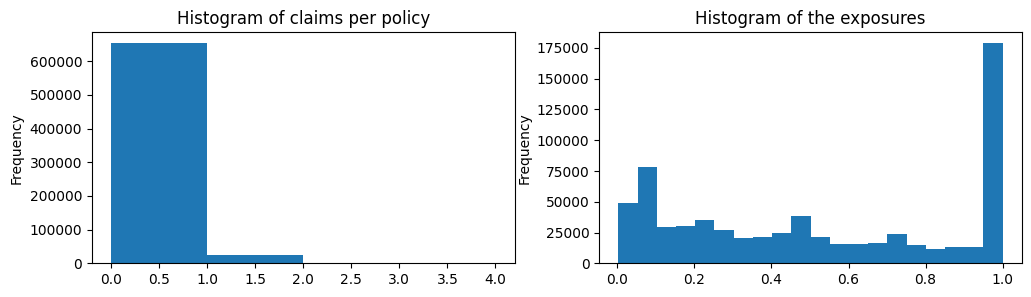

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1.set_title("Histogram of claims per policy")
ax2.set_title("Histogram of the exposures")
df.ClaimNb.plot.hist(bins=4,ax=ax1) #for claimsNB
df.Exposure.plot.hist(bins=20, ax=ax2) #for exposure


In [21]:
# View distribution of all claims
df.ClaimNb.value_counts()

ClaimNb
0.0    653069
1.0     23571
2.0      1298
3.0        62
4.0        13
Name: count, dtype: int64

Most policies have no claims, as might be expected.

There is a significant proportion of policies with exposure value of less than 0.5, so is expected a large difference between the exposure-weighted and the unweighted claims frequency.

Additionally is calculated the *annualized claims frequency* variable.

In [22]:
df['Frequency'] = df['ClaimNb'] / df['Exposure']
df['Frequency'].head(3)

0    0.0
1    0.0
2    0.0
Name: Frequency, dtype: float64

### 1.3.2 Car brand, car age and fuel

In order to highlight the effects of new automobiles, all cars in the plot below that are older than four fall into the same category.

In [23]:
df['VehAge'].unique(), df['VehBrand'].unique(), df['VehGas'].unique()

(array([  0,   2,   1,   9,   8,   4,  10,   5,   3,   6,   7,  15,  25,
         29,  13,  14,  11,  12,  19,  18,  17,  16,  23,  26,  21,  20,
         37,  22,  28,  27,  24,  30,  33,  42,  31,  32,  34,  59,  38,
         39,  46,  35, 100,  43,  44,  36,  40,  78,  99,  48,  41,  47,
         45,  79,  49,  68,  80,  50,  83,  54,  64,  52,  69,  76,  81,
         51,  84,  55,  65,  53,  70,  62,  82,  85,  66,  60,  63,  71]),
 array(['B12', 'B6', 'B3', 'B2', 'B5', 'B10', 'B14', 'B13', 'B4', 'B1',
        'B11'], dtype=object),
 array(['Regular', 'Diesel'], dtype=object))

In [24]:
# do the EDA in a new df and keep the raw data as df
df_eda = df.copy()

df_eda["VehAgeS"] = np.minimum(4, df_eda.VehAge) # limit until 4 years old
df_eda['VehAgeS'].unique()

array([0, 2, 1, 4, 3])

In [26]:
df_eda = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"]).agg(claim_frequency=pd.NamedAgg(column="ClaimNb", aggfunc=sum),
                                                         expo=pd.NamedAgg(column="Exposure", aggfunc=sum))

In [27]:
#frequency for min age 4 years
df_eda.claim_frequency = df_eda.claim_frequency / df_eda.expo

df_eda

claim_frequency         expo
VehBrand VehAgeS VehGas                               
B1       0       Diesel          0.089531  1083.428066
                 Regular         0.050898   825.180752
         1       Diesel          0.085623  2487.651937
                 Regular         0.080686  2094.534500
         2       Diesel          0.085228  2745.586366
...                                   ...          ...
B6       2       Regular         0.065817   531.777345
         3       Diesel          0.095589   439.380085
                 Regular         0.069000   594.201910
         4       Diesel          0.089986  4289.546886
                 Regular         0.072290  8161.573085

[110 rows x 2 columns]

In [28]:
df_eda = df_eda.query("expo >= 100") # exclude groups with low exposure

Text(0.5, 0.98, 'Modified Claims Frequency')

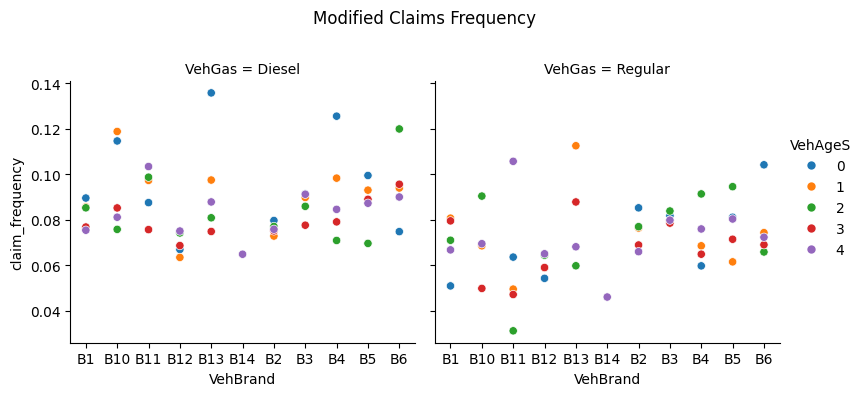

In [29]:
# rp is a FacetGrid. relplot is a nice organized way to use it
rp = sns.relplot(data=df_eda, x='VehBrand', y='claim_frequency', col='VehGas', hue="VehAgeS",
                 palette="tab10", kind='scatter', height=4)
rp.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
rp.fig.suptitle('Modified Claims Frequency')

### 1.3.3 BonusMalus (claims free discount)
since our goal is to limit subsequent models to "BonusMalus" behaviour that increases monotonically, we examine this feature.

In [30]:
# Prepare data and plot

# round feature values for grouping
df_eda = df.copy()
df_eda["BonusMalus"] = np.minimum(df_eda.BonusMalus, 150)
df_eda["BonusMalusGroup"] = np.round(df_eda.BonusMalus/5, 0).astype(int) * 5
df_eda.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold,ClaimNb,Frequency,BonusMalusGroup
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1,0.0,0.0,50
1,3,0.77,D,5,0,55,50,B12,Regular,1217,R82,5,0.0,0.0,50
2,5,0.75,B,6,2,52,50,B12,Diesel,54,R22,1,0.0,0.0,50
3,10,0.09,B,7,0,46,50,B12,Diesel,76,R72,1,0.0,0.0,50
4,11,0.84,B,7,0,46,50,B12,Diesel,76,R72,2,0.0,0.0,50


Z-score for 90% confidence interval: 1.645


<Axes: title={'center': 'Claim frequency (90% CL)'}, xlabel='BonusMalusGroup'>

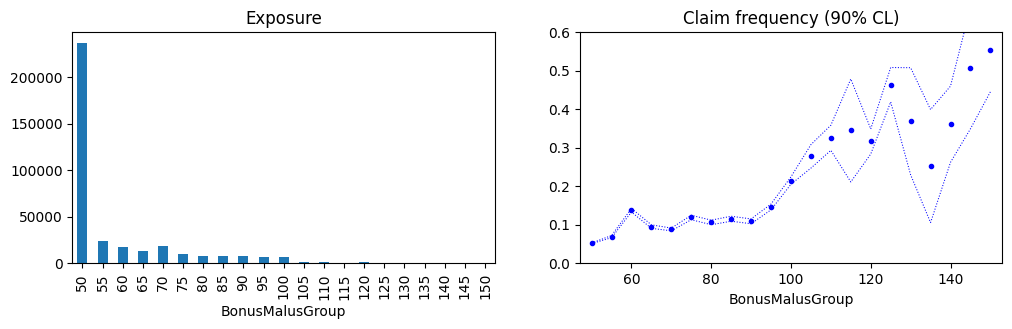

In [31]:
# group by BonusMalusGroup and calculate 90% confidence interval (1.645 sigma)
from scipy.stats import norm
# Calculate the Z-score for a 90% confidence interval
z_score = round(norm.ppf(0.95), 3) #critical value for a given confidence level alpha=0.1, the inverse cumulative distribution function (CDF)
print("Z-score for 90% confidence interval:", z_score) #1.645

frequency = df_eda.groupby("BonusMalusGroup").ClaimNb.sum() / df_eda.groupby("BonusMalusGroup").Exposure.sum()

z = z_score * df_eda.groupby("BonusMalusGroup").ClaimNb.sum()**(1/2) / df_eda.groupby("BonusMalusGroup").Exposure.sum()
frequency = pd.DataFrame(frequency, columns=["Frequency"])
frequency["Upper"] = frequency.Frequency + z
frequency["Lower"] = frequency.Frequency - z

# Generate plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax1.set_title("Exposure")
ax2.set_title("Claim frequency (90% CL)")
df_eda.groupby("BonusMalusGroup").Exposure.sum().plot.bar(ax=ax1)
labels = ax1.get_xticklabels()
frequency.plot(y=["Frequency", "Upper", "Lower"], ylim=(0, 0.6), xlim=(50-3, 153),
               style=[".", ":", ":"], color="bbb", legend=False, lw=0.75, ax=ax2)

most contracts have reached the “50” group with the highest no-claims discount. And  this group has the lowest claims frequency.
The claims frequency curve rises but not monotonically.


## 1.4 Feature preprocessing for GLM

Perform the feature preprocessing

In [33]:
distinct_values_Area= df['Area'].unique()

distinct_values_VehPower= df['VehPower'].unique()
distinct_values_Area, distinct_values_VehPower

(array(['D', 'B', 'E', 'C', 'F', 'A'], dtype=object),
 array([ 5,  6,  7,  4,  9, 15,  8, 10, 12, 11, 14, 13]))

In [34]:
datGLM = df.copy()
datGLM["AreaGLM"] = datGLM.Area.factorize()[0] # from A to E
datGLM["VehPowerGLM"] = np.minimum(9, datGLM.VehPower) # until 9

datGLM.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1157951.00,2272152.00,4046274.00,6.114330e+06
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,0.18,0.49,0.99,1.000000e+00
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.00,6.00,7.00,1.500000e+01
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.00,6.00,11.00,1.000000e+02
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,34.00,44.00,55.00,1.000000e+02
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,50.00,50.00,64.00,2.300000e+02
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,92.00,393.00,1658.00,2.700000e+04
fold,678013.0,2.997021e+00,1.413916e+00,1.000000,2.00,3.00,4.00,5.000000e+00
ClaimNb,678013.0,3.894468e-02,2.050259e-01,0.000000,0.00,0.00,0.00,4.000000e+00
Frequency,678013.0,1.181681e-01,2.005520e+00,0.000000,0.00,0.00,0.00,3.650000e+02


In [35]:
# VehAgeGLM: 3 classes
mapping = {k: 3 if k>=11 else (2 if k>= 1 else 1) for k in range(111)}
datGLM["VehAgeGLM"] = datGLM.VehAge.map(mapping)
datGLM["BonusMalusGLM"] = np.minimum(150, datGLM.BonusMalus) # until 150
datGLM["DensityGLM"] = np.log(datGLM.Density)
datGLM.describe().T

,count,mean,std,min,25%,50%,75%,max
IDpol,678013.0,2.621857e+06,1.641783e+06,1.000000,1.157951e+06,2.272152e+06,4.046274e+06,6.114330e+06
Exposure,678013.0,5.285446e-01,3.640807e-01,0.002732,1.800000e-01,4.900000e-01,9.900000e-01,1.000000e+00
VehPower,678013.0,6.454631e+00,2.050906e+00,4.000000,5.000000e+00,6.000000e+00,7.000000e+00,1.500000e+01
VehAge,678013.0,7.044265e+00,5.666232e+00,0.000000,2.000000e+00,6.000000e+00,1.100000e+01,1.000000e+02
DrivAge,678013.0,4.549912e+01,1.413744e+01,18.000000,3.400000e+01,4.400000e+01,5.500000e+01,1.000000e+02
BonusMalus,678013.0,5.976150e+01,1.563666e+01,50.000000,5.000000e+01,5.000000e+01,6.400000e+01,2.300000e+02
Density,678013.0,1.792422e+03,3.958647e+03,1.000000,9.200000e+01,3.930000e+02,1.658000e+03,2.700000e+04
fold,678013.0,2.997021e+00,1.413916e+00,1.000000,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
ClaimNb,678013.0,3.894468e-02,2.050259e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
Frequency,678013.0,1.181681e-01,2.005520e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.650000e+02


## 1.5 Splitting and encoding data
It will be considered the learning sample randomly.
Learning sample will have 80% and the test sample  20%  of the data records.

The learning sampling will be divide into a *training sample* and a *validation sample*, which is later used for "early stopping", a form of regularisation used to avoid overfitting when training an ML model.

In [36]:
distinct_values= df['fold'].unique()
distinct_values

array([1, 5, 2, 4, 3])

In [38]:
# Function CF2: Print claim frequency
def CF2(txt, l_c, l_x, t_c, t_x):
    print("%s: %.2f %% / %.2f %%" % (txt, sum(l_c)/sum(l_x)*100, sum(t_c)/sum(t_x)*100))

In [39]:
# Defining learn and test sample based on previously defined folds
learn2 = datGLM.loc[datGLM.fold != 5,].copy()    # 80%
test2 = datGLM.loc[datGLM.fold == 5,].copy()     # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn2.ClaimNb, learn2.Exposure, test2.ClaimNb, test2.Exposure)

Claim Frequency (Actual) Learn/Test: 7.37 % / 7.38 %


In [40]:
# Convert categorical variable into dummy/indicator variables.(ONE hot encoding, numbers 0 and 1)
df_ml = pd.get_dummies(df, drop_first=False, dtype='int')
print(df_ml.shape)
df_ml.head(3)

(678013, 51)


,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb,Frequency,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1,0.10,5,0,55,50,1217,1,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,3,0.77,5,0,55,50,1217,5,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,5,0.75,6,2,52,50,54,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# generate sample with encoded data
learn = df_ml.loc[df_ml.fold != 5,].copy()    # 80%
test = df_ml.loc[df_ml.fold == 5,].copy()     # 20%

# Additionally, let's divide learn into train and validation (e.g. to use it for early stopping)
train = df_ml.loc[df_ml.fold < 4,].copy()    # 60%
val = df_ml.loc[df_ml.fold == 4,].copy()    # 20%

CF2("Claim Frequency (Actual) Train/Val", train.ClaimNb, train.Exposure, val.ClaimNb, val.Exposure)

Claim Frequency (Actual) Train/Val: 7.39 % / 7.29 %


In [42]:
# Generate separate datasets for labels (y)(target) and features (X)(predictors)
no_feature_list=['IDpol', 'ClaimNb', 'Exposure', 'Frequency', 'fold']

# labels (ClaimsNb) target
y_train = train.ClaimNb
y_val = val.ClaimNb
y_test = test.ClaimNb
y_learn = learn.ClaimNb

# features predictors
X_train = train.drop(no_feature_list, axis=1)
X_val = val.drop(no_feature_list, axis=1)
X_test = test.drop(no_feature_list, axis=1)
X_learn = learn.drop(no_feature_list, axis=1)

# Get feature names from encoded data
feature_names = X_learn.columns
feature_names

Index(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Area_A',
       'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B1',
       'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13',
       'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4',
       'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular',
       'Region_R11', 'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24',
       'Region_R25', 'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42',
       'Region_R43', 'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72',
       'Region_R73', 'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91',
       'Region_R93', 'Region_R94'],
      dtype='object')

In [43]:
# Display first observations of the learning sample
X_learn.head(3)

,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,Area_C,Area_D,Area_E,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,5,0,55,50,1217,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,6,2,52,50,54,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,46,50,76,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# 2. Generalized Linear Models (GLM)

Focus on driver age

In [44]:
model = smf.glm("ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + BonusMalusGLM \
               + VehBrand + VehGas + DensityGLM +  C(Region)+ AreaGLM + DrivAge + np.log(DrivAge) + \
                I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)",
                family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2) # train the model

# Optimizer: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.fit.html

d_glm2 = model.fit(method='newton') # same results with 'nm', 'IRLS', is commonly used for optimization the Newton-Raphson method
d_glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542962
Model:                            GLM   Df Residuals:                   542914
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -86134.
Date:                Mon, 15 Apr 2024   Deviance:                   1.3166e+05
Time:                        15:59:49   Pearson chi2:                 9.29e+05
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01062
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.7365      0.343    -19.632      0.000      -7.409      -6.064
C(VehPowerGLM)[T.5]     0.0607      0.024      2.484      0.013       0.013       0.109
C(VehPowerGLM)[T.6]     0.0917      0.024      3.827      0.000       0.045       0.139
C(VehPowerGLM)[T.7]     0.0960      0.024      4.047      0.000       0.050       0.142
C(VehPowerGLM)[T.8]     0.1266      0.034      3.759      0.000       0.061       0.193
C(VehPowerGLM)[T.9]     0.2570      0.027      9.654      0.000       0.205       0.309
C(VehAgeGLM)[T.2]       0.0166      0.034      0.487      0.626      -0.050       0.083
C(VehAgeGLM)[T.3]      -0.1679      0.037     -4.586      0.000      -0.240      -0.096
VehBrand[T.B10]        -0.0383      0.045     -0.856      0.392      -0.126       0.049
VehBrand[T.B11]         0.1790      0.046      3.863      0.000       0.088       0.270
VehBrand[T.B12]        -0.2796      0.024    -11.456      0.000      -0.327      -0.232
VehBrand[T.B13]         0.0004      0.051      0.008      0.994      -0.099       0.100
VehBrand[T.B14]        -0.3030      0.104     -2.920      0.004      -0.506      -0.100
VehBrand[T.B2]         -0.0074      0.019     -0.383      0.702      -0.045       0.030
VehBrand[T.B3]          0.0379      0.027      1.417      0.156      -0.015       0.090
VehBrand[T.B4]          0.0305      0.036      0.838      0.402      -0.041       0.102
VehBrand[T.B5]          0.0770      0.031      2.489      0.013       0.016       0.138
VehBrand[T.B6]          0.0408      0.034      1.182      0.237      -0.027       0.108
VehGas[T.Regular]      -0.1689      0.015    -11.321      0.000      -0.198      -0.140
C(Region)[T.R21]       -0.0260      0.129     -0.202      0.840      -0.278       0.226
C(Region)[T.R22]        0.1272      0.068      1.868      0.062      -0.006       0.261
C(Region)[T.R23]       -0.0401      0.080     -0.499      0.617      -0.197       0.117
C(Region)[T.R24]       -0.0230      0.031     -0.735      0.462      -0.084       0.038
C(Region)[T.R25]       -0.0233      0.059     -0.395      0.693      -0.139       0.092
C(Region)[T.R26]        0.0416      0.065      0.644      0.520      -0.085       0.168
C(Region)[T.R31]        0.0163      0.044      0.371      0.711      -0.070       0.103
C(Region)[T.R41]       -0.1066      0.057     -1.864      0.062      -0.219       0.006
C(Region)[T.R42]       -0.0031      0.117     -0.026      0.979      -0.233       0.226
C(Region)[T.R43]       -0.1413      0.191     -0.740      0.459      -0.515       0.233
C(Region)[T.R52]        0.0206      0.038      0.540      0.589      -0.054       0.095
C(Region)[T.R53]       -0.0006      0.037     -0.015      0.988      -0.073       0.072
C(Region)[T.R54]        0.0369      0.048      0.767      0.443      -0.057       0.131
C(R

In [45]:
# make predictions
learn2["fitGLM2"] = d_glm2.predict(learn2) * learn2.Exposure #train model exposure
test2["fitGLM2"] = d_glm2.predict(test2) * test2.Exposure #test model exposure
df["fitGLM2"] = d_glm2.predict(datGLM) * df.Exposure #real exposure

In [46]:
# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fitGLM2, test2.Exposure)
#racio between claimNb and exposure for test dataset (real data),  racio between claimNb and exposure for test dataset predicted model


Claim Frequency GLM2, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %


### (using classes)

In [47]:
model1 = smf.glm("ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + BonusMalusGLM \
               + VehBrand + VehGas + DensityGLM +  C(Region)+ AreaGLM",
                family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2)

# Optimizer: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.fit.html

d_glm3 = model1.fit(method='newton') # same results with 'nm', 'IRLS', is commonly used for optimization the Newton-Raphson method
d_glm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542962
Model:                            GLM   Df Residuals:                   542919
Model Family:                 Poisson   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -86215.
Date:                Mon, 15 Apr 2024   Deviance:                   1.3182e+05
Time:                        16:09:45   Pearson chi2:                 9.24e+05
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01032
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.5123      0.069    -65.502      0.000      -4.647      -4.377
C(VehPowerGLM)[T.5]     0.0638      0.024      2.610      0.009       0.016       0.112
C(VehPowerGLM)[T.6]     0.0960      0.024      4.008      0.000       0.049       0.143
C(VehPowerGLM)[T.7]     0.1058      0.024      4.463      0.000       0.059       0.152
C(VehPowerGLM)[T.8]     0.1401      0.034      4.166      0.000       0.074       0.206
C(VehPowerGLM)[T.9]     0.2654      0.027      9.986      0.000       0.213       0.317
C(VehAgeGLM)[T.2]       0.0163      0.034      0.477      0.633      -0.051       0.083
C(VehAgeGLM)[T.3]      -0.1657      0.037     -4.525      0.000      -0.238      -0.094
VehBrand[T.B10]        -0.0248      0.045     -0.554      0.580      -0.113       0.063
VehBrand[T.B11]         0.1651      0.046      3.564      0.000       0.074       0.256
VehBrand[T.B12]        -0.2683      0.024    -11.005      0.000      -0.316      -0.221
VehBrand[T.B13]         0.0009      0.051      0.017      0.986      -0.098       0.100
VehBrand[T.B14]        -0.3009      0.104     -2.899      0.004      -0.504      -0.097
VehBrand[T.B2]         -0.0074      0.019     -0.386      0.700      -0.045       0.030
VehBrand[T.B3]          0.0144      0.027      0.540      0.589      -0.038       0.067
VehBrand[T.B4]          0.0146      0.036      0.402      0.688      -0.057       0.086
VehBrand[T.B5]          0.0763      0.031      2.465      0.014       0.016       0.137
VehBrand[T.B6]          0.0315      0.034      0.915      0.360      -0.036       0.099
VehGas[T.Regular]      -0.1637      0.015    -11.073      0.000      -0.193      -0.135
C(Region)[T.R21]       -0.0367      0.129     -0.285      0.776      -0.289       0.215
C(Region)[T.R22]        0.1098      0.068      1.613      0.107      -0.024       0.243
C(Region)[T.R23]       -0.0460      0.080     -0.574      0.566      -0.203       0.111
C(Region)[T.R24]       -0.0240      0.031     -0.767      0.443      -0.085       0.037
C(Region)[T.R25]       -0.0270      0.059     -0.459      0.646      -0.143       0.088
C(Region)[T.R26]        0.0430      0.065      0.666      0.505      -0.083       0.169
C(Region)[T.R31]       -0.0050      0.044     -0.113      0.910      -0.091       0.081
C(Region)[T.R41]       -0.1006      0.057     -1.762      0.078      -0.213       0.011
C(Region)[T.R42]       -0.0012      0.117     -0.010      0.992      -0.231       0.228
C(Region)[T.R43]       -0.1787      0.191     -0.936      0.349      -0.553       0.195
C(Region)[T.R52]        0.0177      0.038      0.465      0.642      -0.057       0.093
C(Region)[T.R53]        0.0013      0.037      0.034      0.972      -0.071       0.074
C(Region)[T.R54]        0.0396      0.048      0.822      0.411      -0.055       0.134
C(R

In [48]:
# make predictions
learn2["fitGLM3"] = d_glm3.predict(learn2) * learn2.Exposure
test2["fitGLM3"] = d_glm3.predict(test2) * test2.Exposure
df["fitGLM3"] = d_glm3.predict(datGLM) * df.Exposure

In [49]:
# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM3, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fitGLM3, test2.Exposure)
#racio between claimNb and exposure for test dataset (real data),  racio between claimNb and exposure for test dataset fitted model


Claim Frequency GLM3, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %


The predicted claim frequency is in the learn/test-range and thus fine.